In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import seaborn as sns
import matplotlib.pyplot as plt
from types import MethodType


# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

from tVAE_base.tvae_wrapper import TVAESynthesizer, LossValuesMixin
from tVAE_base.local import load_csvs

from sdv.metadata import Metadata, SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

In [2]:
datasets = load_csvs(folder_name='/home/mfacotti/martin/tVAE_project')

# load data
rhc_data = datasets['rhc']

# Display basic information about the loaded data
print(f"Dataset shape: {rhc_data.shape}")

Dataset shape: (5735, 62)


/home/mfacotti/martin/tVAE_project/tVAE_base/local.py:36: UserWarning:

Ignoring incompatible files ['EDA.ipynb', 'README.md', 'test_metadata_fixed.json', '.gitignore', 'numerical_no_na_metadata.json', 'original_metadata.json', 'delete_first_column_rhc.py', 'test_metadata.json', 'test_model_tvae.pkl', 'generated_metadata.json', 'light_metadata.json', 'ctgan_test.ipynb'] in folder '/home/mfacotti/martin/tVAE_project'.



In [3]:
metadata = SingleTableMetadata()
metadata = Metadata.load_from_json('/home/mfacotti/martin/tVAE_project/original_metadata.json')
metadata.validate()

In [ ]:
model = TVAESynthesizer(
        metadata,
        enforce_min_max_values=True,
        enforce_rounding=True,
        embedding_dim=32,
        compress_dims=(128, 32),
        decompress_dims=(32, 128),
        l2scale=1e-5,
        batch_size=256,
        verbose=True,
        epochs=500,
        loss_factor=2,
)

model.fit(rhc_data)

Loss: 54.184: 100%|██████████| 500/500 [12:43<00:00,  1.53s/it]


Available columns: Index(['Epoch', 'Batch', 'Loss'], dtype='object')


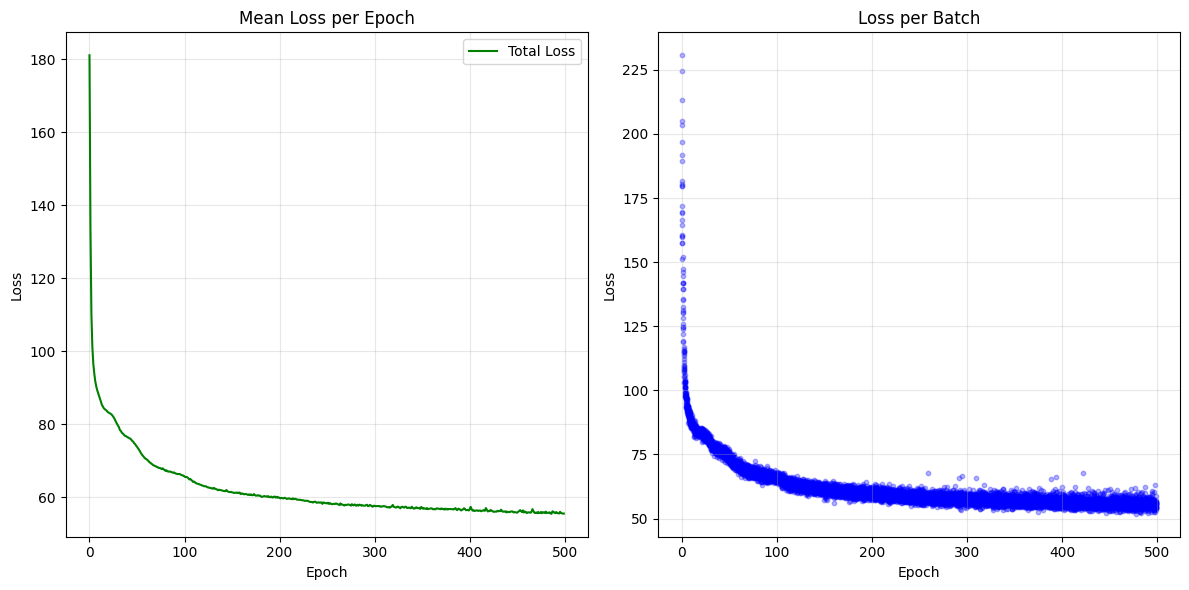

In [5]:
model.plot_loss_over_epochs()

In [8]:
model_name = 'tvae2_ep1000_compress32'
model_filepath = f'test_model_{model_name}.pkl'

In [9]:
model.save(
    filepath=model_filepath
)

In [10]:
synthetic_data = model.sample(
    num_rows=10000,
    batch_size=100
)

output_filename = f'synthetic_data_{model_name}.csv'
synthetic_data.to_csv(output_filename, index=False)

Sampling rows: 100%|██████████| 10000/10000 [00:51<00:00, 192.74it/s]


In [10]:
diagnostic = run_diagnostic(
    real_data=rhc_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 62/62 [00:00<00:00, 585.94it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 159.46it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [11]:
quality_report = evaluate_quality(
    rhc_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 62/62 [00:13<00:00,  4.72it/s]|
Column Shapes Score: 87.03%

(2/2) Evaluating Column Pair Trends: |██████████| 1891/1891 [00:18<00:00, 100.92it/s]|
Column Pair Trends Score: 78.93%

Overall Score (Average): 82.98%



Missing Values Percentage Comparison:
         Real Data (%)  Synthetic Data (%)
cat2         79.075850               92.40
adld3p       74.908457               86.32
urin1        52.798605               52.18
dthdte       35.100262               34.51
dschdte       0.017437                0.02


<Figure size 1400x800 with 0 Axes>

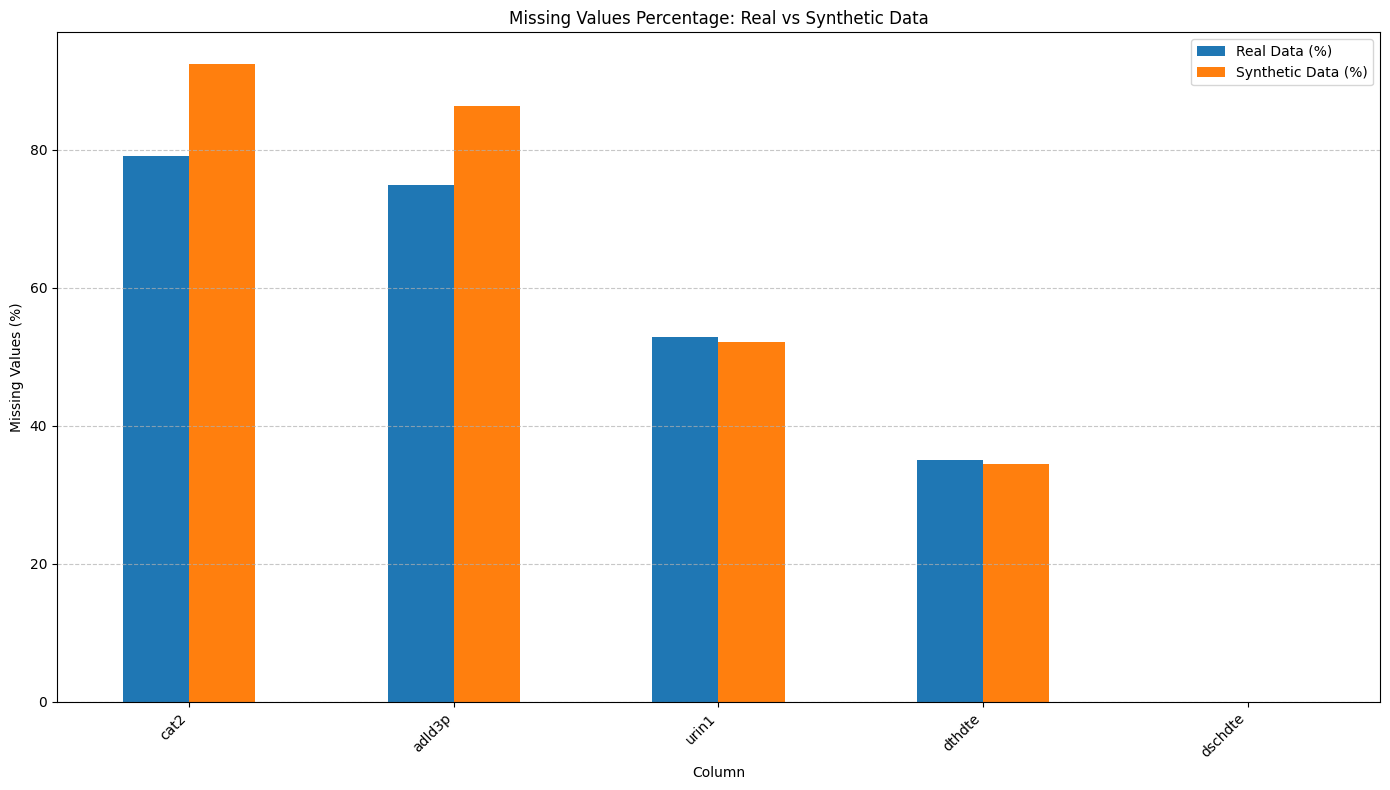

In [12]:
# Compare missing values percentage between real and synthetic data
missing_real = rhc_data.isna().mean().sort_values(ascending=False) * 100
missing_synthetic = synthetic_data.isna().mean().sort_values(ascending=False) * 100

# Filter only columns with missing values
missing_comparison = pd.DataFrame({
    'Real Data (%)': missing_real[missing_real > 0],
    'Synthetic Data (%)': missing_synthetic.reindex(missing_real[missing_real > 0].index)
})

# Display comparison
print("Missing Values Percentage Comparison:")
print(missing_comparison)

# Visualize the comparison
plt.figure(figsize=(14, 8))
missing_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Missing Values Percentage: Real vs Synthetic Data')
plt.ylabel('Missing Values (%)')
plt.xlabel('Column')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()